In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import math
import pandas as pd


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Image from Directory  
Loading the training and test set from a local directory. 20% of the dataset will be for testing and the rest will be for training the model.

In [2]:
def normalize(image, label):
    image = image / 255.0
    image = tf.cast(image, tf.float32)
    return image, label

def load_images(image_size, normalize_images=False):
    from_directory_kwargs = dict(
        directory='images/'
        ,batch_size=32
        ,color_mode='rgb'
        ,image_size=image_size
        ,shuffle=True
        ,seed=29
        ,validation_split=0.20
    )

    ds_train = image_dataset_from_directory(
        subset='training'
        ,**from_directory_kwargs
    )

    ds_val = image_dataset_from_directory(
            subset='validation'
        ,**from_directory_kwargs
    )
    
    if normalize_images:
        ds_train = ds_train.map(normalize)
        ds_val = ds_val.map(normalize)
    
    return ds_train, ds_val
    

In [3]:
IMAGE_SIZE=(224, 224)
ds_train, ds_val = load_images(IMAGE_SIZE, normalize_images=True)

Found 1227 files belonging to 2 classes.
Using 982 files for training.
Found 1227 files belonging to 2 classes.
Using 245 files for validation.


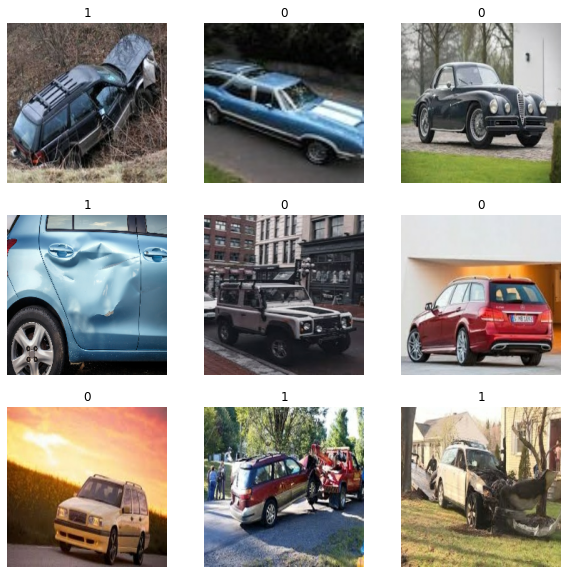

In [4]:
def show_images(dataset, num_of_images=9):

    plt.figure(figsize=(10,10))

    for images, labels in dataset:
        for i in range(num_of_images):
            subplot_shape = math.ceil(num_of_images ** .5)
            ax = plt.subplot(subplot_shape, subplot_shape, i + 1)
            plt.imshow(images[i])
            plt.title(int(labels[i]))
            plt.axis('off')
            
        plt.show()
        break
        
show_images(ds_train, 9)

# Training a model from scratch  
A model will be put together from scratch and trained/tested on the datasets. Iterations will be made to the models in order to improve the performance.  
The goal is to create a model that can accuractly predict whether or not an image of a car has damage to it. The model's accuracy, precision, recall, and AUC scores will be observed.

In [5]:
def run_model(model):
    
    # Load Dataset
    ds_train, ds_val = load_images(IMAGE_SIZE, normalize_images=True)
    
    METRICS = [
        keras.metrics.BinaryAccuracy(name='accuracy')
        ,keras.metrics.Precision(name='precision')
        ,keras.metrics.Recall(name='recall')
        ,keras.metrics.AUC(name='auc')
    ]

    model.compile(
        optimizer=keras.optimizers.Adam()
        ,loss=keras.losses.BinaryCrossentropy(from_logits=False)
        ,metrics=METRICS
    )

    model.fit(ds_train, epochs=5, verbose=2)
    model.evaluate(ds_val, verbose=2)

In [8]:
# Model Creation

# def model1():
#     """
#     This model does not perform well, need to add relu to conv2d
#     """
#     inputs = keras.Input(shape=(224, 224, 3))

#     x = layers.Conv2D(16, 3, padding='valid')(inputs)
#     x = layers.Conv2D(32, 3, padding='valid')(x)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Flatten()(x)
#     x = layers.Dense(100, activation='relu')(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)

#     return keras.Model(inputs=inputs, outputs=outputs)

# model1 = model1()


# def model2():
#     inputs = keras.Input(shape=(224, 224, 3))

#     x = layers.Conv2D(16, 3, padding='valid', activation='relu')(inputs)
#     x = layers.Conv2D(32, 3, padding='valid', activation='relu')(x)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Flatten()(x)
#     x = layers.Dense(100, activation='relu')(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)

#     return keras.Model(inputs=inputs, outputs=outputs, name='model2_relu')

# model2 = model2()


# def model3():
#     """
#     slightly lower accuracy than model 2, lower metrics in general
#     """
#     inputs = keras.Input(shape=(224, 224, 3))
#     x = layers.Conv2D(16, 3, padding='valid')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = keras.activations.relu(x)
#     x = layers.Conv2D(32, 3, padding='valid')(x)
#     x = layers.BatchNormalization()(x)
#     x = keras.activations.relu(x)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Flatten()(x)
#     x = layers.Dense(100, activation='relu')(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)
#     return keras.Model(inputs=inputs, outputs=outputs, name='model2_relu_batchNorm')

# model3 = model3()


# def model4():
#     """
#     Model 2 with MaxPooling after conv
#     """
#     inputs = keras.Input(shape=(224, 224, 3))
#     x = layers.Conv2D(16, 3, padding='valid', activation='relu')(inputs)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Conv2D(32, 3, padding='valid', activation='relu')(x)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Flatten()(x)
#     x = layers.Dense(100, activation='relu')(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)

#     return keras.Model(inputs=inputs, outputs=outputs, name='model2_relu_reformatted')

# model4 = model4()


# def model5():
#     """
#     Model is based on Model4, but with same padding.
#     Results showed unstable increase of recall to about 90%, 
#     but lowered after running 5 more epochs.
    
#     Unstable/Insignificant increases in metrics
#     """
#     inputs = keras.Input(shape=(224, 224, 3))
#     x = layers.Conv2D(16, 3, padding='same', activation='relu')(inputs)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Flatten()(x)
#     x = layers.Dense(100, activation='relu')(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)

#     return keras.Model(inputs=inputs, outputs=outputs, name='model4_sameConv')

# model5 = model5()

# def model6():
#     """
#     Slight improvement by adding extra conv/pool layer
#     """
#     inputs = keras.Input(shape=(224, 224, 3))
#     x = layers.Conv2D(16, 3, padding='valid', activation='relu')(inputs)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Conv2D(32, 3, padding='valid', activation='relu')(x)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Conv2D(64, 3, padding='valid', activation='relu')(x)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Flatten()(x)
#     x = layers.Dense(100, activation='relu')(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)

#     return keras.Model(inputs=inputs, outputs=outputs, name='model6')

# model6 = model6()


# def model7():
#     """
#     Replaced flatten with GAP (global average pooling)
#     Lower metrics overall
#     """
#     inputs = keras.Input(shape=(224, 224, 3))
#     x = layers.Conv2D(16, 3, padding='valid', activation='relu')(inputs)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Conv2D(32, 3, padding='valid', activation='relu')(x)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Conv2D(64, 3, padding='valid', activation='relu')(x)
#     x = layers.MaxPooling2D()(x)
#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dense(100, activation='relu')(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)

#     return keras.Model(inputs=inputs, outputs=outputs, name='model6_GlobalAveragePooling')

# model7 = model7()

# def model8():
#     """
#     Slight improvement by adding extra conv/pool layer
#     longer training time and only slight improvement to AUC
#     """
#     inputs = keras.Input(shape=(224, 224, 3))
#     x = layers.Conv2D(16, 3, padding='valid', activation='relu')(inputs)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Conv2D(32, 3, padding='valid', activation='relu')(x)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Conv2D(64, 3, padding='valid', activation='relu')(x)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Flatten()(x)
#     x = layers.Dense(1000, activation='relu')(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)

#     return keras.Model(inputs=inputs, outputs=outputs, name='model6_Dense_to_1000')

# model8 = model8()


# def model9():
#     """
#     Adding Data Augmentation
#     Lowered overfitting, but reduced overal metrics
#     """
#     data_augmentation = keras.Sequential([
#         layers.experimental.preprocessing.RandomZoom((-0.10, 0.10), (-0.10, 0.10))
#         ,layers.experimental.preprocessing.RandomFlip()
#         ,layers.experimental.preprocessing.RandomContrast(factor=0.10)
#     ])
#     inputs = keras.Input(shape=(224, 224, 3))
#     aug = data_augmentation(inputs)
#     x = layers.Conv2D(16, 3, padding='valid', activation='relu')(aug)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Conv2D(32, 3, padding='valid', activation='relu')(x)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Conv2D(64, 3, padding='valid', activation='relu')(x)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Flatten()(x)
#     x = layers.Dense(100, activation='relu')(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)

#     return keras.Model(inputs=inputs, outputs=outputs, name='model9')

# model9 = model9()


def model10():
    """
    Addming more FC layers
    Significantly increased all metrics
    """
    data_augmentation = keras.Sequential([
        layers.experimental.preprocessing.RandomZoom((-0.10, 0.10), (-0.10, 0.10))
        ,layers.experimental.preprocessing.RandomFlip()
        ,layers.experimental.preprocessing.RandomContrast(factor=0.10)
    ])
    
    inputs = keras.Input(shape=(224, 224, 3))
    aug = data_augmentation(inputs)
    x = layers.Conv2D(16, 3, padding='valid', activation='relu')(aug)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, padding='valid', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding='valid', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dense(50, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return keras.Model(inputs=inputs, outputs=outputs, name='model10')

model10 = model10()

def model11():
    """
    Adding 1 more FC layer
    insignificant changes
    """
    data_augmentation = keras.Sequential([
        layers.experimental.preprocessing.RandomZoom((-0.10, 0.10), (-0.10, 0.10))
        ,layers.experimental.preprocessing.RandomFlip()
        ,layers.experimental.preprocessing.RandomContrast(factor=0.10)
    ])
    
    inputs = keras.Input(shape=(224, 224, 3))
    aug = data_augmentation(inputs)
    x = layers.Conv2D(16, 3, padding='valid', activation='relu')(aug)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, padding='valid', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding='valid', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dense(50, activation='relu')(x)
    x = layers.Dense(25, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return keras.Model(inputs=inputs, outputs=outputs, name='model10_MoreLayers')

model11 = model11()




def model12():
    """
    Remove Augmentation for DataGen
    Slight overfitting
    """
    inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(16, 3, padding='valid', activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, padding='valid', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding='valid', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dense(50, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return keras.Model(inputs=inputs, outputs=outputs, name='model10_NoAug')

model12 = model12()

In [9]:
# USING Image from directory 20210105
models = [
    model10
    ,model11
    ,model12
]

for model in models:
    print(f'\n\nMODEL {model.name}')
    run_model(model)



MODEL model10
Found 1227 files belonging to 2 classes.
Using 982 files for training.
Found 1227 files belonging to 2 classes.
Using 245 files for validation.
Epoch 1/5
31/31 - 1s - loss: 0.6893 - accuracy: 0.5407 - precision: 0.5409 - recall: 0.2537 - auc: 0.5669
Epoch 2/5
31/31 - 1s - loss: 0.6616 - accuracy: 0.6059 - precision: 0.5884 - recall: 0.5821 - auc: 0.6504
Epoch 3/5
31/31 - 1s - loss: 0.6166 - accuracy: 0.6538 - precision: 0.6476 - recall: 0.6034 - auc: 0.7167
Epoch 4/5
31/31 - 1s - loss: 0.5887 - accuracy: 0.6976 - precision: 0.6686 - recall: 0.7271 - auc: 0.7640
Epoch 5/5
31/31 - 1s - loss: 0.5799 - accuracy: 0.6894 - precision: 0.6752 - recall: 0.6738 - auc: 0.7621
8/8 - 0s - loss: 0.5517 - accuracy: 0.7265 - precision: 0.7248 - recall: 0.6810 - auc: 0.7951


MODEL model10_MoreLayers
Found 1227 files belonging to 2 classes.
Using 982 files for training.
Found 1227 files belonging to 2 classes.
Using 245 files for validation.
Epoch 1/5
31/31 - 1s - loss: 0.7001 - accurac

### Evaluation
model10_MoreLayers had only 1 more fully connected layer added to model 10. This model had a slightly lower accuracy and AUC scores.  
model10_NoAug removed the augmentation layer from model10. It can be seen that this caused the model to overfit. In general, after some iterations  
seen in the previous models before, model10 had the best performance with an accuracy of 72% and an AUC of 79%.  

Some steps that can be taken to improve the accuracy is to add more epochs, experiment with different architecures, add more data augmentations,   
and/or include dropout/regularization to help reduce overfitting. I could also try putting the data augmentation step outside of the model so that  
it does not affect the validation set.

# Data generator  
This experiment is to see how a different method of data loading affects model performance.

In [10]:
datagen_kwargs = dict(
    rescale=1./255
    ,validation_split=0.20
    ,dtype=tf.float32
)
dataflow_kwargs = dict(
    target_size=IMAGE_SIZE
    ,shuffle=True
    ,seed=29
    ,batch_size=32
    ,directory='images/'
    ,class_mode='binary'
)


val_datagen = ImageDataGenerator(**datagen_kwargs)
train_datagen = ImageDataGenerator(
    horizontal_flip=True
    ,zoom_range=(0.90, 0.95)
    ,rotation_range=15
    ,**datagen_kwargs
)



ds_val = val_datagen.flow_from_directory(
    subset='validation'
    ,**dataflow_kwargs
)

ds_train = train_datagen.flow_from_directory(
    subset='training'
    ,**dataflow_kwargs
)

Found 245 images belonging to 2 classes.
Found 982 images belonging to 2 classes.


In [12]:
# Reinitializing model10
def model10():
    """
    Addming more FC layers
    Significantly increased all metrics
    """
    data_augmentation = keras.Sequential([
        layers.experimental.preprocessing.RandomZoom((-0.10, 0.10), (-0.10, 0.10))
        ,layers.experimental.preprocessing.RandomFlip()
        ,layers.experimental.preprocessing.RandomContrast(factor=0.10)
    ])
    
    inputs = keras.Input(shape=(224, 224, 3))
    aug = data_augmentation(inputs)
    x = layers.Conv2D(16, 3, padding='valid', activation='relu')(aug)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, padding='valid', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding='valid', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dense(50, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return keras.Model(inputs=inputs, outputs=outputs, name='model10')

model10 = model10()

In [13]:
# Altered the run_model function to work with Datagen
def run_model(model):
    METRICS = [
        keras.metrics.BinaryAccuracy(name='accuracy')
        ,keras.metrics.Precision(name='precision')
        ,keras.metrics.Recall(name='recall')
        ,keras.metrics.AUC(name='auc')
    ]

    model.compile(
        optimizer=keras.optimizers.Adam()
        ,loss=keras.losses.BinaryCrossentropy(from_logits=False)
        ,metrics=METRICS
    )

    model.fit(ds_train, epochs=5, verbose=2, steps_per_epoch=982//32)  # 982 is number of training images
    model.evaluate(ds_val, verbose=2)

In [14]:
# Running model with Datagen
print(f'\n\nMODEL {model.name}')
run_model(model10)



MODEL model10_NoAug
Epoch 1/5
30/30 - 7s - loss: 0.6988 - accuracy: 0.5232 - precision: 0.5000 - recall: 0.5519 - auc: 0.5115
Epoch 2/5
30/30 - 7s - loss: 0.6835 - accuracy: 0.5411 - precision: 0.6429 - recall: 0.0796 - auc: 0.5814
Epoch 3/5
30/30 - 7s - loss: 0.6530 - accuracy: 0.6211 - precision: 0.5896 - recall: 0.6755 - auc: 0.6638
Epoch 4/5
30/30 - 7s - loss: 0.6344 - accuracy: 0.6337 - precision: 0.6559 - recall: 0.4912 - auc: 0.6936
Epoch 5/5
30/30 - 7s - loss: 0.6136 - accuracy: 0.6653 - precision: 0.6293 - recall: 0.7025 - auc: 0.7197
8/8 - 0s - loss: 0.8352 - accuracy: 0.5143 - precision: 0.4500 - recall: 0.0769 - auc: 0.5765


### Evaluation
The first observation is that the model trained much slower at 7s per epoch using datagen, compared to the 1s per epoch using image_dataset_from_directory.  
The performance of the model is also lower which can be seen in the significantly lower accuracy, precision, recall, and AUC scores.  

Some next steps to be taken is to research why using this method is causing the model to not only train slower, but also perform worse.  
The method for using datagen should also be looked into to confirm that it is being done correctly.

# Transfer Learning / Fine Tuning  
Several already developed architectures and their weights will be loaded and trained on this dataset.  
The base transfered model's weights will be frozen to prevent training. A dropout layer and a fully connected output layer will be added  
to the base model and these 2 layers will be trained on 3 epochs. The base transfered model will then be unfrozen and the entire model will  
be fine-tuned by training on 3 more epochs. The performance metrics of accuracy, precision, recall, and AUC will be observed. 

In [26]:
# Storing the model logic in a function
def transfer_learning(url, shape):
    # Loading data
    img_height = shape[0]
    img_width = shape[1]
    ds_train, ds_val = load_images((img_height,img_width), normalize_images=True)
    
    # Base Model
    if url == 'xception':
        base_model = keras.applications.Xception(
            weights='imagenet'
            ,include_top=False
            ,input_shape=shape
        )
        base_model.trainable = False
        
    else:
        base_model = hub.KerasLayer(
            url
            ,trainable=False
        )
    
    # Final Model
    inputs = keras.Input(shape=shape)
    base = base_model(inputs)
    if url == 'xception':
        base = layers.Flatten()(base)
    x = layers.Dropout(0.2)(base)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    final_model = keras.Model(inputs=inputs, outputs=outputs)
    
    # Training
    print('########### Transfer Learning ###########')
    METRICS = [
        keras.metrics.BinaryAccuracy(name='accuracy')
        ,keras.metrics.Precision(name='precision')
        ,keras.metrics.Recall(name='recall')
        ,keras.metrics.AUC(name='auc')
    ]

    final_model.compile(
        optimizer=keras.optimizers.Adam()
        ,loss=keras.losses.BinaryCrossentropy(from_logits=False)
        ,metrics=METRICS
    )

    final_model.fit(ds_train, epochs=3, verbose=0)
    final_model.evaluate(ds_val, verbose=2)
    
    # Fine Tuning
    print('\n########### Fine Tuning ###########')
    base_model.trainable = True
    
    final_model.compile(
        optimizer=keras.optimizers.Adam(1e-5)
        ,loss=keras.losses.BinaryCrossentropy(from_logits=False)
        ,metrics=METRICS
    )

    final_model.fit(ds_train, epochs=3, verbose=0)
    
    return final_model.evaluate(ds_val, verbose=2)

In [27]:
models_to_train = {
    'mobilenet_v2': {
        'url': 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
        ,'shape': (224, 224, 3)
    }
    ,'resnet50': {
        'url': 'https://tfhub.dev/tensorflow/resnet_50/feature_vector/1'
        ,'shape': (224, 224, 3)
    }
    ,'efficientnet_b1': {
        'url': 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
        ,'shape': (224, 224, 3)
    }
    ,'xception': {
        'url': 'xception'
        ,'shape': (150, 150, 3)
    }
    ,'inception_v3': {
        'url': 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4'
        ,'shape': (299, 299, 3)
    }
    ,'nasnet': {
        'url': 'https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4'
        ,'shape': (224, 224, 3)
    }
}

In [28]:
# Training all models and storing their results in model_results
model_results = {}
for name, info in models_to_train.items():
    try:
        url = info.get('url')
        shape = info.get('shape')
        print('\n' + '=' * 100)
        print(f"TRAINING {name}\n")
        results = transfer_learning(url, shape)

        model_results[name] = {
            'loss': results[0]
            ,'accuracy': results[1]
            ,'precision': results[2]
            ,'recall': results[3]
            ,'auc': results[4]
        }
    except Exception as err:
        print(f'failed to train model {name}... {err}')


TRAINING mobilenet_v2

Found 1227 files belonging to 2 classes.
Using 982 files for training.
Found 1227 files belonging to 2 classes.
Using 245 files for validation.
########### Transfer Learning ###########
8/8 - 0s - loss: 0.3265 - accuracy: 0.8612 - precision: 0.8727 - recall: 0.8276 - auc: 0.9400

########### Fine Tuning ###########
8/8 - 0s - loss: 0.3692 - accuracy: 0.8939 - precision: 0.9327 - recall: 0.8362 - auc: 0.9562

TRAINING resnet50

Found 1227 files belonging to 2 classes.
Using 982 files for training.
Found 1227 files belonging to 2 classes.
Using 245 files for validation.
########### Transfer Learning ###########
8/8 - 1s - loss: 0.3105 - accuracy: 0.8531 - precision: 0.8509 - recall: 0.8362 - auc: 0.9413

########### Fine Tuning ###########
8/8 - 1s - loss: 0.5893 - accuracy: 0.8857 - precision: 0.8793 - recall: 0.8793 - auc: 0.9635

TRAINING efficientnet_b1

Found 1227 files belonging to 2 classes.
Using 982 files for training.
Found 1227 files belonging to 2 clas

In [60]:
results_df = pd.DataFrame(model_results).transpose()
results_df.sort_values('accuracy', ascending=False)

,loss,accuracy,precision,recall,auc
mobilenet_v2,0.369190,0.893878,0.932692,0.836207,0.956161
resnet50,0.589307,0.885714,0.879310,0.879310,0.963546
inception_v3,0.540045,0.877551,0.930000,0.801724,0.951116
efficientnet_b1,0.476308,0.857143,0.824000,0.887931,0.941693
nasnet,0.734002,0.853061,0.877358,0.801724,0.934309
xception,0.459689,0.812245,0.812500,0.784483,0.894179


## Evaluation  
The best performing transfer model was mobilenet_v2 which was able to correctly classify 89% of the images as wreck or not. It can be seen that this model performed the best in accuracy, precision, and recall.  
It's AUC was second only to the resnet50 model, which was also a really well performing model.  

Some improvements to the fine-tuned mobilenet_v2 could be made by training and fine-tuning the model for longer. Data augmentation can also be looked at to see if that increases how well the models perform.  
The lower recall value could also be improved on, perhaps having more images of wrecked(or damaged) cars will allow the model to capture them better.

# Project Conclusion  
Trying to build out my own deep learning image classifier has been a great learning experience. Working through this project I had learned how to obatain large amounts of images off the internet,  
how to write my own program to efficiently label my dataset, how to build models using the tensorflow library, how a basic computer vision architecture is set up as well as the basics behind computer vision deep learning models.  
I was also able to experiment with different models that I developed to see how each iteration affected the performance. Finally, I was able to experiment with transfer learning on many different pre-trained models  
and fine-tune them on my own dataset.

This project is definitely not perfect, but I was able to learn a ton! There is still so much more to learn and improve on and I am excited for the future projects I will work on.